To run and test this you will need to: 

- source the species_classifier kernel
- download the following files: 
    - `01_uk_macro_data_numeric_labels.json`: for labeling the data
    - `turing-macro_v01_efficientnetv2-b3_*.pt`: the model files
    - `test-500-{000000..0000*}.tar` : the test data files

In [3]:
#!pip install protobuf==3.20.0
import sys
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/02_model_training/pytorch')

In [4]:
from evaluation.micro_accuracy_batch import MicroAccuracyBatch
from evaluation.micro_accuracy_batch import add_batch_microacc, final_microacc
from evaluation.macro_accuracy_batch import MacroAccuracyBatch
from evaluation.macro_accuracy_batch import (
    add_batch_macroacc,
    final_macroacc,
    taxon_accuracy,
)
from evaluation.confusion_matrix_data import confusion_matrix_data
from evaluation.confusion_data_conversion import ConfusionDataConvert

In [5]:
from torchvision import transforms
import torch
import os
import numpy as np
import tensorflow as tf
import csv
import json
from PIL import Image
import PIL
import onnx
from typing import Literal
from typing_extensions import Literal
import matplotlib.pyplot as plt
import timm

2023-10-20 15:22:27.345694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 15:22:29.324895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 15:22:43.833537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Steps to Compress

In [6]:
#!pip install -U dm-sonnet==1.23
#!pip install --upgrade tfp-nightly

In [7]:
import onnx
from onnx_tf.backend import prepare
from data2 import dataloader

/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [8]:
# Load in the pytorch model
model_py = torch.load("/bask/homes/f/fspo1218/amber/projects/on_device_classifier/outputs/turing-macro_v01_efficientnetv2-b3_2023-10-20-13-55.pt", map_location='cpu')

In [9]:
# Load in the test data
test_dataloader = dataloader.build_webdataset_pipeline(
        sharedurl="/bask/homes/f/fspo1218/amber/data/binary_moth_training/gbif_crop_ready/datasets/macro/test/test-500-{000000..000001}.tar",
        input_size=1000,
        batch_size=64,
        is_training=False,
        num_workers=4,
        preprocess_mode="tf",
    )
print("images loaded")

image_dummy, label_dummy = next(iter(test_dataloader))
image_batch = image_dummy.to("cpu", non_blocking=True)
label_batch = label_dummy.to("cpu", non_blocking=True)



images loaded


In [10]:
label = label_batch[0]
image = image_batch[0]
print(int(label))

139


In [11]:
# Label info for the species names
f = open("/bask/homes/f/fspo1218/amber/data/binary_moth_training/gbif_crop_ready/01_uk_macro_data_numeric_labels.json")
label_info = json.load(f)
species_list = label_info["species_list"]
print(len(species_list), " species in total")

990  species in total


In [12]:
# convert to onnx
torch.onnx.export(
            model=model_py.eval(),
            args=image.unsqueeze(0),
            f="/bask/homes/f/fspo1218/amber/data/compressed_models/species/onnx_file_cropped.onnx",
            verbose=False,
            export_params=True,
            do_constant_folding=False,
            input_names=['input'],
            opset_version=12,
            output_names=['output']
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [13]:
# Convert to tf
onnx_model = onnx.load("/bask/homes/f/fspo1218/amber/data/compressed_models/species/onnx_file_cropped.onnx")
onnx.checker.check_model(onnx_model)
tf_rep = prepare(onnx_model, device='CPU')
tf_rep.export_graph("/bask/homes/f/fspo1218/amber/data/compressed_models/species/tf_file_cropped")

2023-10-20 15:26:06.985238: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Assets written to: /bask/homes/f/fspo1218/amber/data/compressed_models/species/tf_file_cropped/assets


INFO:tensorflow:Assets written to: /bask/homes/f/fspo1218/amber/data/compressed_models/species/tf_file_cropped/assets


# Steps to Evaluate the Tensorflow model

We have a working tensorflow model. Lets test one image

In [12]:
#interpreter = tf.lite.Interpreter(model_path="/bask/homes/f/fspo1218/amber/data/compressed_models/species/")
#interpreter.allocate_tensors()

In [13]:
# # Load in the test data
# test_dataloader = dataloader.build_webdataset_pipeline(
#         sharedurl="./outputs/test-500-{000000..000013}.tar",
#         input_size=1000,
#         batch_size=64,
#         is_training=False,
#         num_workers=4,
#         preprocess_mode="tf",
#     )
# print("images loaded")

# image_dummy, label_dummy = next(iter(test_dataloader))
# image_batch = image_dummy.to("cpu", non_blocking=True)
# label_batch = label_dummy.to("cpu", non_blocking=True)


In [14]:
def plot_predictions(image_index, ax):
    image = image_batch[image_index]
    image = image.unsqueeze(0)

    label = label_batch[image_index]

    output = tf_rep.run(image)

    true_str = "True: " + species_list[int(label)]
    pred_str = "Pred: " + species_list[np.argmax(output)]
    text = "Image " + str(image_index)

    ax.imshow(image_batch[image_index].permute(1, 2, 0))
    ax.tick_params(axis='both', which='both', bottom=False, 
                top=False, left=False, right=False, 
                labelbottom=False, labelleft=False) 

    # add annotation label to the plot
    ax.annotate(text, (50, 50), color='white')
    ax.annotate(true_str, (50, 850), color='white')
    ax.annotate(pred_str, (50, 900), color='white')

2023-10-20 15:26:38.388592: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_3/Assert/AssertGuard/branch_executed/_29


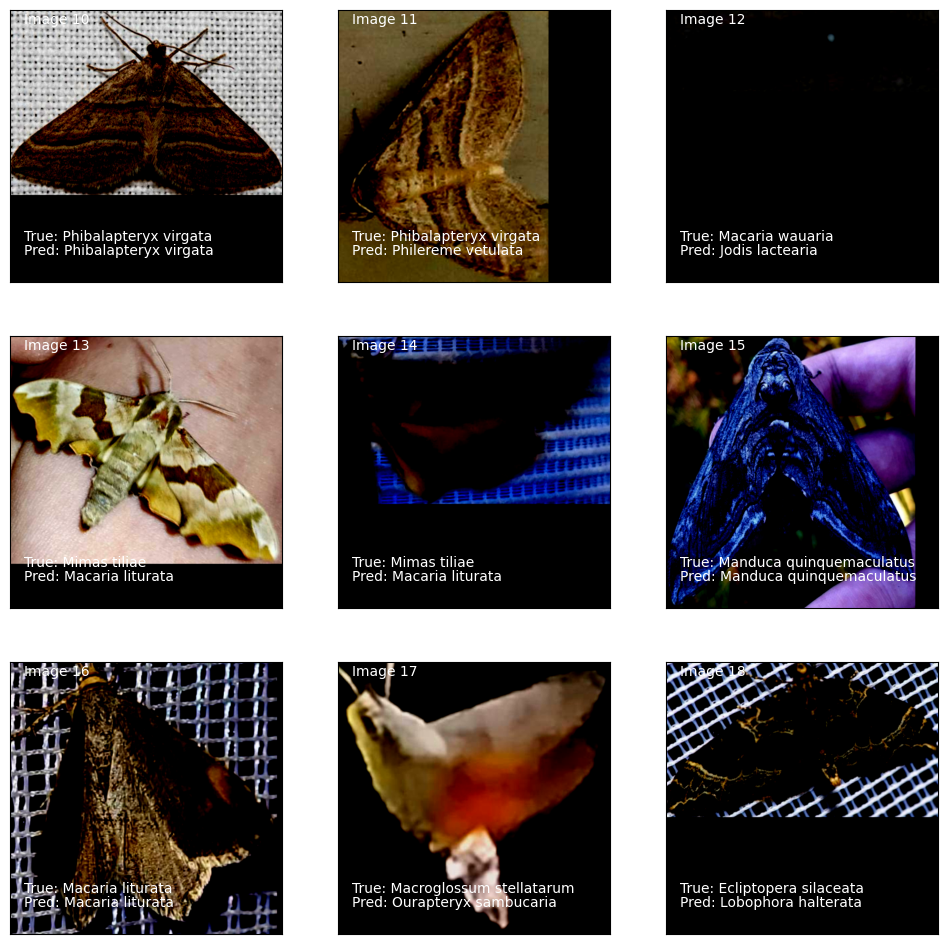

In [15]:
# matplotlib subplots 3x3
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

plot_predictions(10, axs[0, 0])
plot_predictions(11, axs[0, 1])
plot_predictions(12, axs[0, 2])
plot_predictions(13, axs[1, 0])
plot_predictions(14, axs[1, 1])
plot_predictions(15, axs[1, 2])
plot_predictions(16, axs[2, 0])
plot_predictions(17, axs[2, 1])
plot_predictions(18, axs[2, 2])

plt.savefig('/bask/homes/f/fspo1218/amber/data/compressed_models/species/example_predictions2.png')

# Convert to TF Lite model

In [17]:
# Convert to tfLite
converter = tf.lite.TFLiteConverter.from_saved_model("/bask/homes/f/fspo1218/amber/data/compressed_models/species/tf_file_cropped")
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True
tflite_model = converter.convert()

2023-10-20 15:28:46.377109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-20 15:28:46.377980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-20 15:28:46.379661: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /bask/homes/f/fspo1218/amber/data/compressed_models/species/tf_file_cropped
2023-10-20 15:28:46.418041: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-20 15:28:46.418716: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /bask/homes/f/fspo1218/amber/data/compressed_models/species/tf_file_cropped
2023-10-20 15:28:46.470841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-20 15:28:46.480121: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-10-20 15:28:46.714984: I ten

In [18]:
with open("/bask/homes/f/fspo1218/amber/data/compressed_models/species/compressed_model_cropped.tflite", 'wb') as f:
    f.write(tflite_model)

# Evaluating the TFLite Model 

Load the model

In [19]:
model = tf.lite.Interpreter(model_path="/bask/homes/f/fspo1218/amber/data/compressed_models/species/compressed_model_cropped.tflite")
model.allocate_tensors()

INFO: Created TensorFlow Lite delegate for select TF ops.
2023-10-20 15:29:04.186190: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: TfLiteFlexDelegate delegate: 1 nodes delegated out of 665 nodes with 1 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Load the species label information

In [20]:
device="cpu"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/bask/homes/f/fspo1218/amber/data/compressed_models/species/compressed_model_cropped.tflite")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()
print("tflite model loaded")

tflite model loaded


2023-10-20 15:29:10.364590: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


🚨🚨 warning: the next cell will take a while to run 🚨🚨

In [21]:
global_microacc_data = None
global_macroacc_data = None
global_confusion_data_sp = None
global_confusion_data_g = None
global_confusion_data_f = None

f = open('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/02_model_training/pytorch/configs/01_uk_macro_data_config_cropped.json')
config_data = json.load(f)
taxon_hierar = config_data["dataset"]["taxon_hierarchy"]
label_info = config_data["dataset"]["label_info"]

In [22]:
label_batch[0]

tensor(139)

In [23]:
f = open(taxon_hierar)
taxon_info = json.load(f)


In [24]:
def species_to_genus_gt(taxon_hierar, species):
        """
        returns the genus of a species for the ground truth
        """
        f = open(taxon_hierar)
        taxon_info = json.load(f)
        genus_list = []

        for item in species:
            genus_list.append(taxon_info[item][0])

        return genus_list

def species_to_family_gt(taxon_hierar, species):
        """
        returns the family of a species for the ground truth
        """
        f = open(taxon_hierar)
        taxon_info = json.load(f)
        family_list = []

        for item in species:
            family_list.append(taxon_info[item][1])

        return family_list

In [25]:
# Label info for the species names
f = open(label_info)
f = json.load(f)
species_list = f["species_list"]
print(len(species_list), " species in total")

990  species in total


In [26]:
headers = ['True_label', 'True_family', 'True_genus', 'True_label_index', 
           'Pytorch_prediction', 'Pytorch_family', 'Pytorch_genus', 'Pytorch_prediction_index', 
           'TFLite_prediction','TFLite_family', 'TFLite_genus', 'TFLite_prediction_index', 
           'Pytorch_top10', 'Pytorch_top3', 'Pytorch_top1', 'TFLite_top10', 'TFLite_top3', 'TFLite_top1', '\n']

with open('/bask/projects/v/vjgo8416-amber/projects/on_device_classifier/02_model_training/pytorch/myfile.csv','w', newline="") as fd:
    fd.write(','.join(headers))

In [27]:
counter = 1
for image_batch, label_batch in test_dataloader:
    print('new batch', counter)
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)

    for i in range(len(image_batch)):
        image = image_batch[i]
        label = label_batch[i]

        # For pytorch model
        outputs_py = model_py(image.unsqueeze(0))        
        _, prediction_py10 = torch.topk(outputs_py, 10) #the indices for the top 10 predictions
        _, prediction_py3 = torch.topk(outputs_py, 3)
        _, prediction_py1 = torch.topk(outputs_py, 1)

        in_top_10_py = 1 if int(label) in np.array(prediction_py10.cpu()) else 0
        in_top_3_py = 1 if int(label) in np.array(prediction_py3.cpu()) else 0
        in_top_1_py = 1 if int(label) in np.array(prediction_py1.cpu()) else 0

        # For the tensorflow lite model
        interpreter.set_tensor(input_details[0]['index'], image.unsqueeze(0))
        interpreter.invoke()
        outputs_tf = interpreter.get_tensor(output_details[0]['index'])
        prediction_tf = np.squeeze(outputs_tf)
        prediction_tf = prediction_tf.argsort()[::-1]

        in_top_10_tf = 1 if int(label) in prediction_tf[0:10] else 0
        in_top_3_tf = 1 if int(label) in prediction_tf[0:3] else 0
        in_top_1_tf = 1 if int(label) == prediction_tf[0] else 0
        
        species_to_family_gt(taxon_hierar, ['Leucania loreyi'])[0]

        true_species = species_list[int(label)]
        pytorch_species = species_list[int(prediction_py1[0])]
        tflite_species = species_list[prediction_tf[0]]

        line = [#'True_label', 'True_family', 'True_genus', 'True_label_index', 
                true_species, species_to_family_gt(taxon_hierar, [true_species])[0], species_to_genus_gt(taxon_hierar, [true_species])[0], str(int(label)), 
                #'Pytorch_prediction', 'Pytorch_family', 'Pytorch_genus', 'Pytorch_prediction_index', 
                pytorch_species, species_to_family_gt(taxon_hierar, [pytorch_species])[0], species_to_genus_gt(taxon_hierar, [pytorch_species])[0], str(int(prediction_py1[0])),
                #TFLite_prediction','TFLite_family', 'TFLite_genus', 'TFLite_prediction_index', 
                tflite_species, species_to_family_gt(taxon_hierar, [tflite_species])[0], species_to_genus_gt(taxon_hierar, [tflite_species])[0], str(prediction_tf[0]),
                #'Pytorch_top10', 'Pytorch_top3', 'Pytorch_top1', 'TFLite_top10', 'TFLite_top3', 'TFLite_top1'
                str(int(in_top_10_py)), str(int(in_top_3_py)), str(int(in_top_1_py)), 
                str(int(in_top_10_tf)), str(int(in_top_3_tf)), str(int(in_top_1_tf)), '\n']
        line = ','.join(line)
        with open('/bask/projects/v/vjgo8416-amber/projects/on_device_classifier/02_model_training/pytorch/myfile.csv','a') as fd:
            fd.write(line)
    counter = counter + 1      
        
        

new batch 1
new batch 2
new batch 3
new batch 4
new batch 5
new batch 6
new batch 7
new batch 8
new batch 9
new batch 10
new batch 11
new batch 12
new batch 13
new batch 14
new batch 15
new batch 16
new batch 17
new batch 18
new batch 19
new batch 21
new batch 22
new batch 23


# Test the system when using TFLite inference

In [25]:
import wandb

# check its not loading the subdirectory
print(wandb.__path__)

['/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/wandb']


In [28]:
wandb.init(
    project="gbif",
    entity="kg-test", 
    tags="tflite"
    settings=wandb.Settings(start_method="fork")
)

counter = 0
for image_batch, label_batch in test_dataloader:
    print('new batch', counter)
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)

    for i in range(len(image_batch)):
        image = image_batch[i]
        label = label_batch[i]

        # For the tensorflow lite model
        interpreter.set_tensor(input_details[0]['index'], image.unsqueeze(0))
        interpreter.invoke()
        outputs_tf = interpreter.get_tensor(output_details[0]['index'])
        prediction_tf = np.squeeze(outputs_tf)
        prediction_tf = prediction_tf.argsort()[::-1]

        in_top_10_tf = 1 if int(label) in prediction_tf[0:10] else 0
        in_top_3_tf = 1 if int(label) in prediction_tf[0:3] else 0
        in_top_1_tf = 1 if int(label) == prediction_tf[0] else 0
        
        species_to_family_gt(taxon_hierar, ['Leucania loreyi'])[0]

        true_species = species_list[int(label)]
        tflite_species = species_list[prediction_tf[0]]

        line = {'counter':counter, 'True_label':true_species, 'True_family':species_to_family_gt(taxon_hierar, [true_species])[0], 
                'True_genus':species_to_family_gt(taxon_hierar, [true_species])[0], 'True_label_index':str(int(label)),
                'TFLite_prediction':tflite_species,'TFLite_family':species_to_family_gt(taxon_hierar, [tflite_species])[0], 
                'TFLite_genus':species_to_genus_gt(taxon_hierar, [tflite_species])[0], 'TFLite_prediction_index':str(prediction_tf[0]), 
                'TFLite_top10':str(int(in_top_10_tf)), 'TFLite_top3':str(int(in_top_3_tf)), 'TFLite_top1':str(int(in_top_1_tf))
               }

        wandb.log(line)
        counter = counter + 1  
        
wandb.finish()

new batch 0
new batch 64
new batch 128
new batch 192
new batch 256
new batch 320
new batch 384
new batch 448
new batch 512
new batch 576
new batch 640
new batch 704
new batch 768
new batch 832
new batch 896
new batch 960
new batch 1024
new batch 1088
new batch 1152
new batch 1216
new batch 1280
new batch 1344
new batch 1408
new batch 1472
new batch 1536
new batch 1600
new batch 1664
new batch 1728
new batch 1792
new batch 1856
new batch 1920
new batch 1984
new batch 2048
new batch 2112
new batch 2176
new batch 2240
new batch 2304
new batch 2368
new batch 2432
new batch 2496


KeyboardInterrupt: 

In [ ]:
test_dataloader.batch_size

64

In [ ]:
wandb.init(
    project="gbif",
    entity="kg-test", 
    tags="tflite",
    settings=wandb.Settings(start_method="fork")
)


counter = 1
for image_batch, label_batch in test_dataloader:
    print('new batch', counter)
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)

    for i in range(len(image_batch)):
        image = image_batch[i]
        label = label_batch[i]

        # For pytorch model
        outputs_py = model_py(image.unsqueeze(0))        
        _, prediction_py10 = torch.topk(outputs_py, 10) #the indices for the top 10 predictions
        _, prediction_py3 = torch.topk(outputs_py, 3)
        _, prediction_py1 = torch.topk(outputs_py, 1)

        in_top_10_py = 1 if int(label) in np.array(prediction_py10.cpu()) else 0
        in_top_3_py = 1 if int(label) in np.array(prediction_py3.cpu()) else 0
        in_top_1_py = 1 if int(label) in np.array(prediction_py1.cpu()) else 0

        true_species = species_list[int(label)]
        pytorch_species = species_list[int(prediction_py1[0])]

        line = {'counter':counter, 'True_label':true_species, 'True_family':species_to_family_gt(taxon_hierar, [true_species])[0], 
                'True_genus':species_to_family_gt(taxon_hierar, [true_species])[0], 'True_label_index':str(int(label)),
                'Pytorch_prediction':pytorch_species,'Pytorch_family':species_to_family_gt(taxon_hierar, [pytorch_species])[0], 
                'Pytorch_genus':species_to_genus_gt(taxon_hierar, [pytorch_species])[0], 'Pytorch_prediction_index':str(prediction_py1[0]), 
                'Pytorch_top10':str(int(in_top_10_py)), 'Pytorch_top3':str(int(in_top_3_py)), 'Pytorch_top1':str(int(in_top_1_py))
               }
        wandb.log(line)
        counter = counter + 1  

wandb.finish()